## Income classifier

Written by Henry Harfouche.

## Getting Started

The goal of this project is to classify individuals on whether or not they make more then 50,000 or not. The motivation behind this idea is that individuals who earn more then $50,000 are more likely to donate to a charity of their chosing.

The data obtained is from a 1994 U.S. Census. In this notebook I will run you through the process and design choices in building a standard supervised machine learning model

The dataset for this project originates from the [UCI Machine Learning Repository] The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
First and foremost we need to explore and investigate the data we collected. First we import all our python libraries that will help us with this investigation

In [32]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
data.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration

We are going to do a EDA (exploratory data analysis) here. By no means is this completely extensive, it is a quick recap so that I can get used to the data and know what to expect. In addition, I know the dataset has already been curated so I expect it to need a bit of work but not too much.

In [33]:
# How are income variables represented:
data.income.unique()

array(['<=50K', '>50K'], dtype=object)

There are 2 unique strings which indicate the income groups: '<=50k' and '>50K'

In [34]:
n_records = data.shape[0]

group_sizes = data.groupby(['income']).size()

group_sizes = pd.DataFrame(group_sizes, columns= ['count']).reset_index()
group_sizes = pd.concat([group_sizes, pd.Series(n_records).repeat(2).reset_index(drop=True)], axis = 1).rename(columns={0:'total'})
group_sizes['percentage'] = group_sizes['count'] / group_sizes['total']

group_sizes

,income,count,total,percentage
0,<=50K,34014,45222,0.752156
1,>50K,11208,45222,0.247844


We can see that 75% of the people in our data set make 50K or less and that this number represents 34,014 people.
<br>In the other category, we have 11,208 participants and that group represents 25% of our population

** Featureset Exploration **

This represents the values in our other columns. I will be shifting through these columns really quickly

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

#### The following is rough work to get a quick feel for the data

### Age

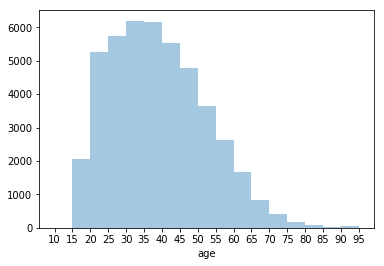

In [35]:
import seaborn as sb
import matplotlib.pyplot as plt

bins = np.arange(10,100,5)

sb.distplot(data.age, bins=bins, kde=False)
locs, labels= plt.xticks()
plt.xticks(bins);

Looks like our age data is Right Skewed

### Workclass

In [36]:
data.workclass.value_counts()

 Private             33307
 Self-emp-not-inc     3796
 Local-gov            3100
 State-gov            1946
 Self-emp-inc         1646
 Federal-gov          1406
 Without-pay            21
Name: workclass, dtype: int64

Most people work for a private corporation

### Education level

In [37]:
data.education_level.value_counts()

 HS-grad         14783
 Some-college     9899
 Bachelors        7570
 Masters          2514
 Assoc-voc        1959
 11th             1619
 Assoc-acdm       1507
 10th             1223
 7th-8th           823
 Prof-school       785
 9th               676
 12th              577
 Doctorate         544
 5th-6th           449
 1st-4th           222
 Preschool          72
Name: education_level, dtype: int64

In 1994, the highest education category was High school 

### Education-number of years

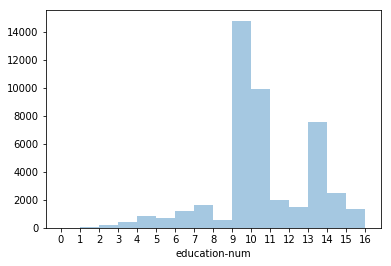

In [38]:
data['education-num'].value_counts()

bins = np.arange(0,data['education-num'].max()+1,1)

sb.distplot(data['education-num'], bins=bins, kde=False)
locs, labels= plt.xticks()
plt.xticks(bins);

### Marital-status

In [39]:
data['marital-status'].value_counts()

 Married-civ-spouse       21055
 Never-married            14598
 Divorced                  6297
 Separated                 1411
 Widowed                   1277
 Married-spouse-absent      552
 Married-AF-spouse           32
Name: marital-status, dtype: int64

### Occupation

In [40]:
data.occupation.value_counts()

 Craft-repair         6020
 Prof-specialty       6008
 Exec-managerial      5984
 Adm-clerical         5540
 Sales                5408
 Other-service        4808
 Machine-op-inspct    2970
 Transport-moving     2316
 Handlers-cleaners    2046
 Farming-fishing      1480
 Tech-support         1420
 Protective-serv       976
 Priv-house-serv       232
 Armed-Forces           14
Name: occupation, dtype: int64

### Relationship

In [41]:
data.relationship.value_counts()

 Husband           18666
 Not-in-family     11702
 Own-child          6626
 Unmarried          4788
 Wife               2091
 Other-relative     1349
Name: relationship, dtype: int64

### Race

In [42]:
data.race.value_counts()

 White                 38903
 Black                  4228
 Asian-Pac-Islander     1303
 Amer-Indian-Eskimo      435
 Other                   353
Name: race, dtype: int64

### Sex/gender

In [43]:
data.sex.value_counts()

 Male      30527
 Female    14695
Name: sex, dtype: int64

### Capital-gains

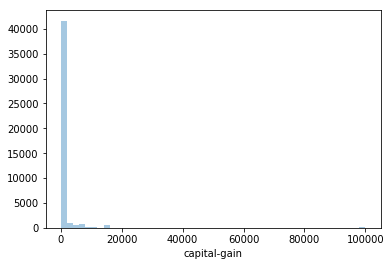

In [44]:
sb.distplot(data['capital-gain'], kde=False);
#set y limits

this one looks heavily skewed. We will need to transform the data. Most of the values are below 20,000 while there are some individuals who are near 100,000

### Capital Loss

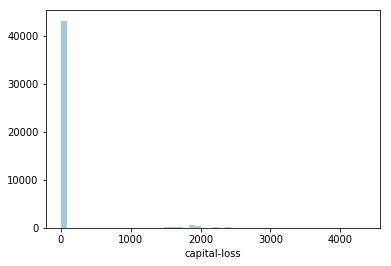

In [45]:
sb.distplot(data['capital-loss'], kde=False);

Same observation here, the data will ned to be transformed

### Work hours per week

In [46]:
data['hours-per-week'].min(),data['hours-per-week'].max(), data['hours-per-week'].describe()

(1.0, 99.0, count    45222.000000
 mean        40.938017
 std         12.007508
 min          1.000000
 25%         40.000000
 50%         40.000000
 75%         45.000000
 max         99.000000
 Name: hours-per-week, dtype: float64)

In [47]:
data['native-country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
       ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
       ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
       ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
       ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
       ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
       ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
       ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
       ' Hungary', ' Holand-Netherlands'], dtype=object)

----
## Preparing/Preprocessing the data

This is important to do because it will help with our model's accuracy and predictive power. If we do not perform the preprocessing steps below we will get very different and innacurate results.


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

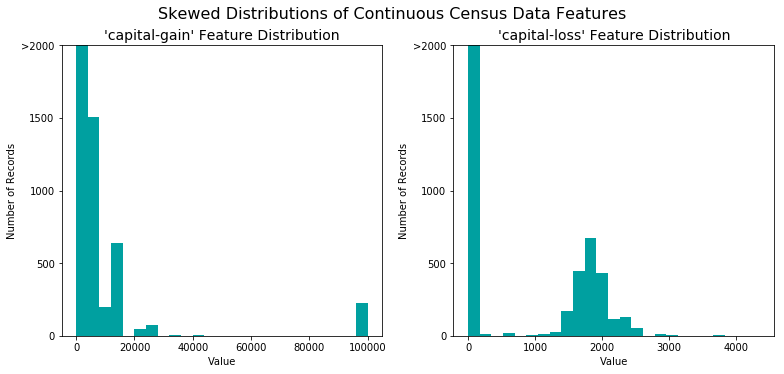

In [48]:
# Splitting the data into features and target label (target = income_raw)
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

Because the data is highly skewed, I will use a logarithmic transformation to rebalance everything... that way really large and really small data do not negatively affect the performance of the model.

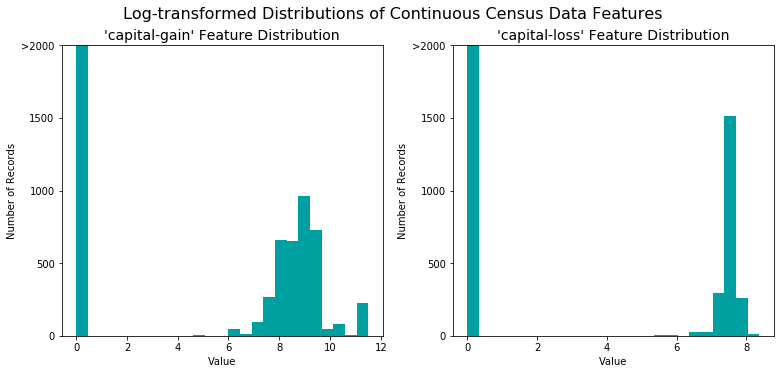

In [49]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
#need to do +1 because log 0 does not exist
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))  

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

Now that the highly skewed data has been transformed on a log scale, I will normaliaze the numerical data. This is to ensure that all columns are treated equally as oppsoed to the model assigning more weight to a numerically larger category. For example, the age category ranged from 1 to 99 but the capital gain category ranges from 0-11 as we can see from the work above.

<br> Normalizing these values means that they will all be between 0-1

In [50]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

For non-numeric data, we can use a process called one-hot-encoding to represent them in columns in order to be able to use these. Pandas has a great function which does this easily. One-hot-encoding is transforming categorical data in such a way that they are represented in seperate columns. For example: if you have 1 category and it has A, B or C as values, one-hot-encoding replaces the column and creates 3 new columns called A, B and C. Depending on the value of the column the row will get a 1 to indicate the category or a 0.  

In [51]:
features_log_minmax_transform.columns

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [52]:
# Time to one-hot encode the categorical variables, we can pass other columns that are normalized and they will not be affected
features_final = pd.get_dummies(features_log_minmax_transform)

income = pd.get_dummies(income_raw)
income = income['>50K']

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. We will now split the data into training and test sets. 80% of the data will be used for training and 20% for testing. Pandas lets us do this very quickly and effectively


In [53]:
from sklearn.model_selection import train_test_split

# Spliting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

One important distinction when we are doing modelling is to find out 'how much better our model is' then just blindly picking labels. In this case we can predict that everyone makes more then 50,000 and look at our accuracy and f-score.

TP = True Positive  (our model predicts a 1 and in reality its a 1)
FP = False Positive (our model predicts its a 1 when in reality it should be a 0)
TN = True Negative  (our model predicts a 0 and in reality its a 0)
FN = False Negative (our model predicts its a 0 when in reality it should be a 1)

In [54]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.

# the naive predictor our the naive way of doing this problem is picking everybody as 1s
FP = income.count() - TP 

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculate F-score for beta = 0.5
beta = 0.5
fscore = (1 + beta **2) * precision*recall / ((beta**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


There are also libraries in python which can do this for us very quickly, for example accuracy_score in sklearn.metrics can do this very quickly.

In [55]:
from sklearn.metrics import accuracy_score, fbeta_score

accuracy_score(income,np.ones(len(income))), fbeta_score(income, np.ones(len(income)), beta = 0.5)

(0.24784396974923709, 0.29172913543228385)

###  Supervised Learning Models

scikit-learn contains many different models which we can fit our data to. These models need to work for classification problems since we are predicting something True/False in nature (The individual makes more then 50,000 ==> True/False). 

I've decided to use Decision Trees, a Bagging Classifier and a Random Forest Classifier. You may look at the write-up in Report.pdf to understand everything about these models and why they are appropriate here. To keep everything short, decision trees is the simplest decision making model, then there is a bagging classifiers which try to improve the accuracy by reducing variance, finally there Random Forests are even more accurate then both methods because it creates multiple decision trees by considering a small subest of the features and ultimately picks the consensus on all trees for each data point.

### Implementation - Creating a Training and Predicting Pipeline

What we are doing here is creating a pipeline, basically you can call this function with most models and it will work and return what we want.

We are going to test out the predictions on the first 300 data points

In [56]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 1)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

BaggingClassifier trained on 362 samples.
BaggingClassifier trained on 3618 samples.
BaggingClassifier trained on 36177 samples.



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.



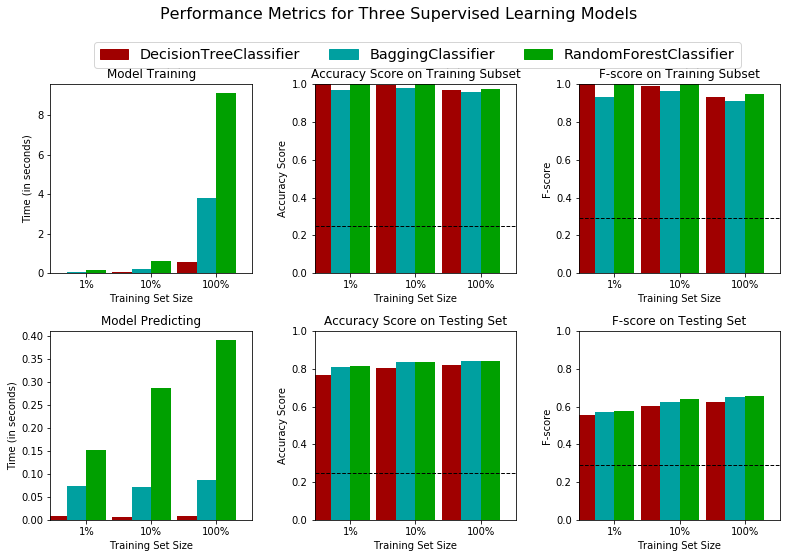

In [57]:
from tqdm import tqdm_notebook as tqdm
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

clf_A = tree.DecisionTreeClassifier(random_state = 0)
clf_B = BaggingClassifier(random_state = 0)
clf_C = RandomForestClassifier(random_state = 0,n_estimators=100)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)


samples_100 = len(X_train)
samples_10 = round(0.1*samples_100)
samples_1 =  round(0.01*samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in tqdm(enumerate([samples_1, samples_10, samples_100])):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

We can also look at the results below, basically we ran our test data in our model and then recalculated our accuracy/f-score on the train set and test set. What is important to look at here is the f_test accuracy because that is how well our model generalizes to new unseen data. In the last graph in the bot right, the green bar (Random Forest) did the best. Looking at our dictionary for the specific values, the Random Forest also performed the best

In [58]:
results

{'DecisionTreeClassifier': {0: {'train_time': 0.003409147262573242,
   'pred_time': 0.009130477905273438,
   'acc_train': 1.0,
   'acc_test': 0.76705362078496409,
   'f_train': 1.0,
   'f_test': 0.55595363540569021},
  1: {'train_time': 0.036072731018066406,
   'pred_time': 0.0068645477294921875,
   'acc_train': 0.9966666666666667,
   'acc_test': 0.80431177446102819,
   'f_train': 0.99300699300699302,
   'f_test': 0.60278276481149018},
  2: {'train_time': 0.559943437576294,
   'pred_time': 0.009374141693115234,
   'acc_train': 0.96999999999999997,
   'acc_test': 0.81857379767827532,
   'f_train': 0.93430656934306566,
   'f_test': 0.62405498281786931}},
 'BaggingClassifier': {0: {'train_time': 0.043918609619140625,
   'pred_time': 0.07311677932739258,
   'acc_train': 0.96999999999999997,
   'acc_test': 0.80851299060254289,
   'f_train': 0.93430656934306566,
   'f_test': 0.57213438735177868},
  1: {'train_time': 0.2191615104675293,
   'pred_time': 0.07146000862121582,
   'acc_train': 0.9

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Implementation: Model Tuning

Here I am going to tune the Random Forest using grid search. This is where you can input a few combinations for the model hyperparameters and the computer will try all of these and pick the best combination.

In [59]:
%%time
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

#the best model was the Random Forest Classifier

# TODO: Initialize the classifier
clf = RandomForestClassifier(random_state = 0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = { 'n_estimators': [100,200], 
              'min_samples_split' : [2,10,20], 
              'min_samples_leaf' :  [2,10,20] }


# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5, average = 'binary')

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Unoptimized model
------
Accuracy score on testing data: 0.8378
F-score on testing data: 0.6717

Optimized Model
------
Final accuracy score on the testing data: 0.8611
Final F-score on the testing data: 0.7318
CPU times: user 11min 26s, sys: 112 ms, total: 11min 26s
Wall time: 11min 28s


In [60]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8377       |     0.8612      |
| F-score        |      0.6716       |   0.7321        |


The optimized model's accuracy is 0.8612 (or 86.12%) while the F-score is 0.7321. These scores are higher thent he Unoptimized Model as seen in the table above. The Accuracy improved by around 2.5% while hte F-score improved by 6% <br><br>

The naive predictor benchmarks were the following: [Accuracy score: 0.2478, F-score: 0.2917] and thus we can see that there was a tremendous improvement with the Unoptomized and Optimized model. 


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We can accomplish this in python using  the features_importance function

In [61]:
data.columns

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Just looking at the columns, I would assume that these features to be the most important: 'age', 'capital-gain', 'occupation',  education level, workclass. The following explanations are based on my intution. Again this data is from 1994 in the USA:

<br><br> Age: Odds are, older adults have more work experience and life experience then younger adults so they probable have higher salaries/income then younger adults.
<br>Capital-Gain: if an individual has higher capital-gains then he would have more disposable income. Capital-gains come from investments so that is probably a really good indicator of salary level. This feature might be even more important then Age, since if you are a relatively young but you have high capital-gains then odds are you have a higher salary.
<br>Occupation: certain occupations make more then others so this feature can help us.
<br>Education level: individuals who have higher degrees probably earn more then those who don't. For example a person with a Master's/PhD will most likely earn more then somebody who only graduated High School
<br>Workclass: I feel like the workclass can also be another good indicator... wether the person is Self-employed, or works for a government or the private sector... these labels can help us determine their income levels
<br>

### Implementation - Extracting Feature Importance

Now we will use python

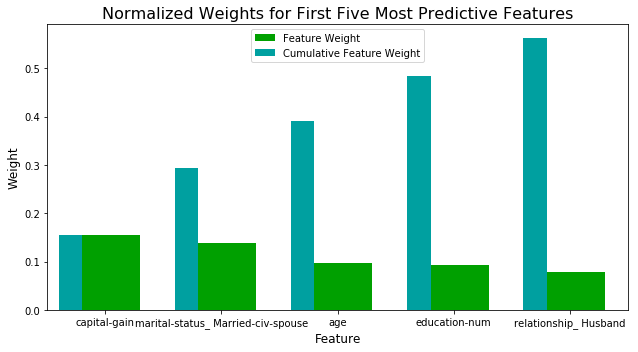

In [62]:
# I am just going to use the best model we found fromt the last section since it was optimized...

importances = best_clf.feature_importances_

indices = np.argsort(importances)

# Plot
vs.feature_plot(importances, X_train, y_train)

### Results and interpretations

It looks like Capital-gain is the most important feature. I had this ranked at number 2 behind age. Age here is ranked as the third most important factor so we were pretty close. It's hard to completely discribe the relationship. I would assume Age is a good indicator until maybe the age of 60 when people tend in 1994 tend to retire so they probably start easing off their work hours/income.

<br> Besides this, I overlooked the Marriage part. I figured it wasn't that important but if I take some time and think about this ranking makes sense. If you have a higher income, you are probably more likely to get married. Also, I would also assume that high earners also marry other high earners so if you are successful enough to get Married you probably have a job that pays at least $50,000.

<br> As for education, it seems that the number of education years is more important then the education level. I was pretty close here and I also had this attribute at #4 except I aggregated this by education levels whereas it seems that the education years is a better predictor.

<br><br> Finaly, I was a bit shocked at the last  predictor, 'relationship-husband' but I guess it makes sense... we've all heard about how men make more then women and if that's not True today it was probably true in 1994 when this census was taken... Also, back then, the traditional family roles were probably more prevalent then today so odds are the Husband had to make more to take care of the family (while the wife stayed at home to raise the children).

#### References

http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

https://medium.com/@harishkandan95/bagging-the-skill-of-bagging-bootstrap-aggregating-83c18dcabdf1

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

http://www.stat.cmu.edu/~ryantibs/datamining/lectures/24-bag.pdf

https://upsaily.com/blog/application-of-decision-trees-in-sales-campaign/

https://pdfs.semanticscholar.org/cdba/6a87bef89ce9650af70dc81436d9f3d28025.pdf